In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras 
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.models import Sequential,load_model
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,GlobalAveragePooling2D,Dropout
from keras.preprocessing import image
import cv2
import pickle

In [3]:
labels=pd.read_csv("C:\\Users\Dell\OneDrive\Desktop\dog_breed\labels.csv")

In [4]:
sample=pd.read_csv("C:\\USers\Dell\OneDrive\Desktop\dog_breed\sample_submission.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
def app_jpg(id):
    return id+".jpg"

In [7]:
labels['id']=labels['id'].apply(app_jpg)
sample['id']=sample['id'].apply(app_jpg)

In [9]:
datagen=Imgen(preprocessing_function=keras.applications.nasnet.preprocess_input,
              shear_range=0.2,
              zoom_range=0.2,
              horizontal_flip=True,
              validation_split=0.1
              )

In [12]:
train_ds=datagen.flow_from_dataframe(
    labels,
    directory='C:\\Users\Dell\OneDrive\Desktop\dog_breed\\train',
    x_col='id',
    y_col='breed',
    subset="training",
    color_mode="rgb",
    target_size=(331,331),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=123,
)
val_ds=datagen.flow_from_dataframe(
    labels,
    directory='C:\\Users\Dell\OneDrive\Desktop\dog_breed\\train',
    x_col='id',
    y_col='breed',
    subset="validation",
    color_mode="rgb",
    target_size=(331,331),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=123,
)

Found 9200 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.


In [13]:
a=train_ds.class_indices
class_names=list(a.keys())
class_names[:10]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

In [14]:
x,y=next(train_ds)
x.shape

(32, 331, 331, 3)

In [16]:
def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

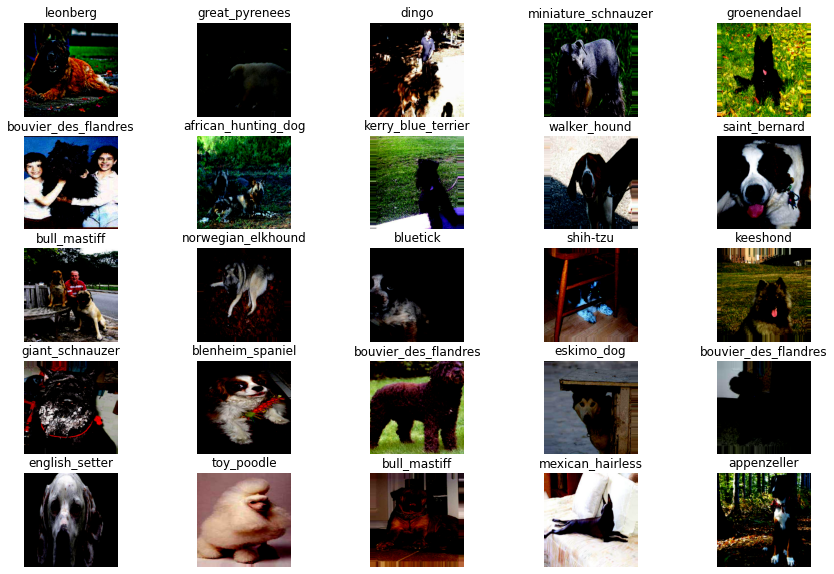

In [17]:
plot_images(x,y)

In [18]:
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [22]:
base_model=InceptionResNetV2(include_top=False,
                             weights='imagenet',
                             input_shape=(331,331,3)
                             )
base_model.trainable=False

219070464/219055592 [==============================] - 1594s 7us/step


In [23]:
model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256,activation='relu'),
    Dropout(0.5),
    Dense(120,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 9, 9, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
Total params: 54,761,048
Trainable params: 424,312
Non-trainable params: 54,336,736
_________________________________________________________________


In [25]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [27]:
my_calls=[keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
          keras.callbacks.ModelCheckpoint("Model.h5",verbose=1,save_best_only=True)]

In [28]:
hist=model.fit(train_ds,epochs=1,validation_data=val_ds,callbacks=my_calls)

288/288 [==============================] - 2518s 9s/step - loss: 1.3378 - accuracy: 0.7374 - val_loss: 0.3106 - val_accuracy: 0.9129

Epoch 00001: val_loss improved from inf to 0.31065, saving model to Model.h5


In [29]:
model=load_model("./Model.h5")

In [31]:
testgen=Imgen(preprocessing_function=keras.applications.inception_resnet_v2.preprocess_input)

In [32]:
test_ds=testgen.flow_from_dataframe(
    sample,
    directory='C:\\Users\Dell\OneDrive\Desktop\dog_breed\\test',
    x_col='id',
    y_col=None,
    target_size=(331,331),
    class_mode=None,
    batch_size=32,
    shuffle=False
)

Found 109 validated image filenames.


In [33]:
predictions=model.predict(test_ds,verbose=1)

4/4 [==============================] - 31s 7s/step


In [34]:
pred=[np.argmax(i) for i in predictions]

In [35]:
X=next(test_ds)
X.shape

(32, 331, 331, 3)

In [36]:
def check_images(img):
    plt.figure(figsize=[10,25])
    for i in range(32):
        plt.subplot(8,4,i+1)
        plt.imshow(img[i])
        plt.title(class_names[pred[i]])
        plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

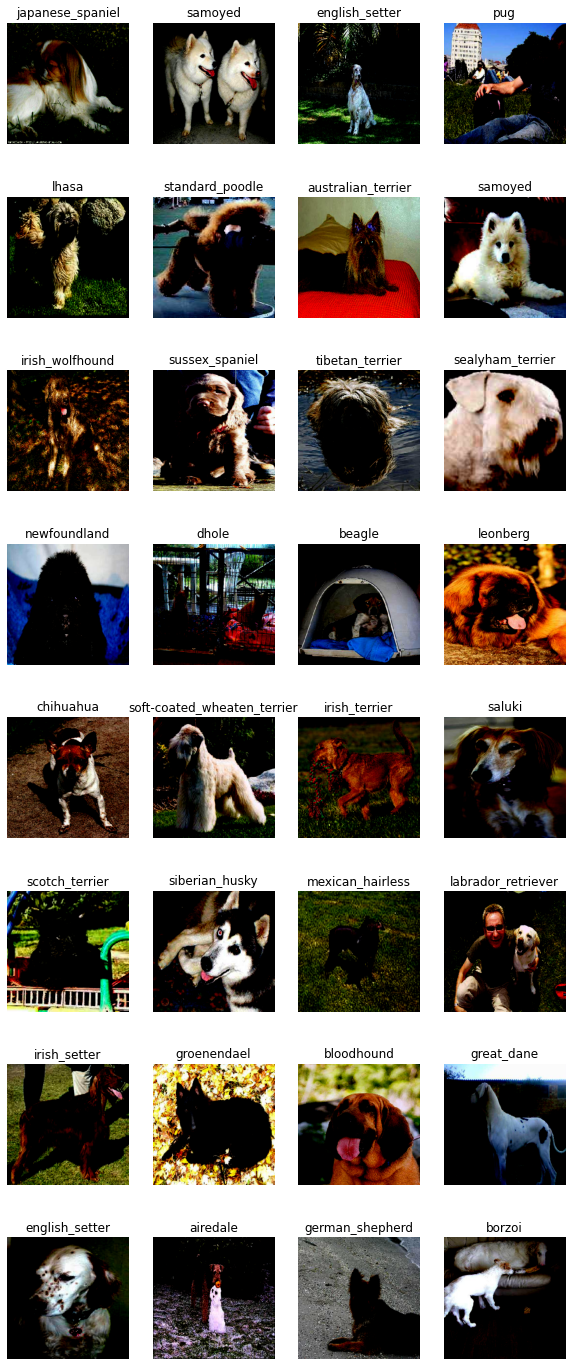

In [37]:
check_images(X)